A placeholder template for my writeup with the necessary code and details. Fill in and commit gradually. This statement should be the last thing to be edited.

Some type of intro

# 1. Objective

Though a complicated process, the goal I set out to achieve is quite straightforward. I wanted to conduct every process necessary to prepare data for, develop, and evaluate a predictive model - solely by the hand of my own math. This includes the development of the model itself, as well as the various mechanisms required to conduct feature engineering and model evaluation. I chose to build a random forest classifier because (among other reasons listed below during our discussion of the properties of random forests and decision trees) the algorithm gave me a manageable level of control through its hyperparameters, which I felt was crucial. Random forests are also robust to outliers and compatible with different data types, which was a flexibility I valued greatly. 

Besides `pandas` and `numpy`, I used standard python packages like `random` and `collections`, but I didn't want any pre-built data science functionalities so I eschewed packages like `sci-kit-learn`.

In [1]:
import numpy as np
import pandas as pd
import random
from pprint import pprint
from collections import Counter
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

To train and test my model I chose to use a toy dataset that was a twist on a classic - the *Spaceship Titanic* dataset (which can be found here): https://www.kaggle.com/c/spaceship-titanic. 

The original Titanic dataset is probably one of the most, if not the most, famous toy dataset in the world of data science learning - the dataset exhibits a number of numerical and categorical features for each passenger of the Titanic (age, number of family members, gender, cabin, etc.), with its target being a variable of two levels (whether the passenger in question survived or not). 

The Spaceship Titanic dataset is a spiritual sibling - though its features are also properties of passengers (now on a spaceship), the target depicts whether said passenger has been transported to their goal location or not. I chose this dataset because of its mix of categorical and numerical features, which I felt would play most interestingly with the abilities of the random forest classifier. 

In [2]:
main_data = pd.read_csv('train.csv')

- Any credits 

# 2. Logic Behind Decision Trees

In short, random forest algorithms are collections of a number of different decision trees, which are predictive algorithms themselves. Each decision tree predicts an outcome, and the random forest algorithm returns the most popular outcome among the decision trees (for example, if I had a random forest classifier with 100 decision trees, and 75 of them voted that a particular passenger had been transported, that is what the random forest model would predict).

Therefore, it's beneficial to talk about and implement the inner workings of decision trees, and take a look at optimization strategies to craft the best ones. 

## The Basic Structure

Let's say we had a dataset consisting of four children that either do or don't play the popular phone game Roblox:

    - Rob - is 11, a boy, and does NOT play roblox
    - Dan - is 6, a boy, and does play roblox
    - Monica - is 8, a girl, and does play roblox 
    - Selena - is 12, a girl and does NOT play roblox

Suppose I'm presented with a new child:

    - is 7, and a girl

A decision tree would look at each different feature and find the split within that feature that best separates those that play roblox with those that do not. In this case, the features are the genders and ages of the children. 

The decision tree might ask "is the child a boy or a girl?", and find that of the girls, 1 plays roblox and 1 doesn't, and likewise for the boys. After that question is asked, the data is split between boys and girls. Each of these separate results is called a **node**. The childen in question is a girl, so we continue down to the node which has only female children in its data. We can then ask the question of age - "is the child over $10$ or under $10$ years old?", taking note that the girl under, Monica, plays roblox, whereas the girl over 10, Selena, does not. Therefore, this question splits the data into two **pure nodes** - nodes in which the target value of all instances included are the same. 

Then, we can use the logic of the decision tree to generate a prediction based on those nodes. Here are the splits, with $P$ and $DP$ representing "plays roblox" and "does not play roblox" respectively. 

*with **X** representing an instance in the dataset*:

$X$ age $<=10$:

    - Y --> Node(Dan, Monica) = (P, P)
    - N --> Node(Rob, Selena) = (NP, NP)

Since our test child is less than 10 years old, she most likely plays roblox. 

Our goal is to develop decision trees that end in pure nodes - this implies that the decision tree was able to find splits among features that can directly lead to instances which are only one class or the other. That way, each test instance to predict can be sorted question by question and be associated with a node with a definitive target level. 

Obviously, there are two big questions here:

1. How deep should our tree be? 
2. How do we determine what splits to make? 

To understand the answer to these questions, we need to take a look at the metrics we use to optimize our tree's performance and the bias/variance tradeoff associated. 

## Entropy and Information Gain

### Entropy

Let's tackle the second question first. 

Because at the end of the day, all predictive modeling is a collection of mathematical directions and key performance metrics, the quantities and mathematical logic we use to codify decision trees are crucial to their interpretability and optimizability. Decision trees choose the best splits for their nodes using the probabilistic measures of entropy and information gain (which is a kind of cumulative entropy measure).  

The formula for entropy is as follows: 

$H(X) = -\sum_{i=1}^{n} P(x_i) \cdot \log_b(P(x_i)) $, 

with $b$ conventionally a value of $2$. 

In simpler terms, the entropy is the negative sum of the probabilities of data in a node (probability of each instance being one of any levels of the target class - in this case, either the probability that the children in one node play roblox or don't). 

Let's say, in our former example, we split the dataset by asking the gender question (*is the child a boy or a girl?*). We'd then have two nodes.

The first node:

    - Rob and Dan

The second node:

    - Monica and Selena

To calculate the entropy of the first node, we must first note that the probability of a child in that node playing or not playing roblox is $0.5$, since each outcome has a $1$ in $2$ chance. Then, $ P(x_i) \cdot \log_b(P(x_i) $ for each outcome comes to a value of $-0.5$. Taking the negative sum of both log probabilities results in a value of $1$ - the highest entropy can possibly be. This is because there is a perfect diversity in the dataset for that node, since of its two members, there is an equal number that plays or doesn't play roblox. 

Let's assume now, that in some situation we reach a pure node (where all instances are of one class), in which each child in that node's dataset plays roblox. Note that the probabilities now are $1$ and $0$, which result in log values of $0$ and $0$. Therefore, entropy is minimized when the node reaches a pure state.

Put simply, entropy is the state of disorder in a dataset. The more decisive one collection of instances is (the strength of its probability going one way or another), the weaker the entropy. 

There is one other concept we should visit: 

### Information Gain 

The formula for Information Gain is as follows: 

$ \text{Gain}(X, Y) = \text{Entropy}(X) - \sum_{i=1}^{n} \frac{|X_i|}{|X|} \cdot \text{Entropy}(X_i) $, 

with feature $Y$ (age/gender) splitting the data $X$ into subsets. $|X_i|$ and $|X|$ represent the number of instances in each split's dataset and the whole dataset, respectively. 

For binary splits (questions which split nodes into 2 choices, the formula is the following):

$IG(X) = -H(X) + (\frac{|X_L|}{|X|}\cdot H(X_L)) + (\frac{|X_R|}{|X|}\cdot H(X_R))$,

Where $X_L$ is the "left" split of the data, and $X_R$ is the "right split. (For example, if the question were "*is the child over 10?*", the "left" split would contain Dan and Monica, and the right would contain Rob and Selena). The "directions" are arbitrary and serve mainly to differentiate the two datasets. 

Essentially we calculate the negative of the entropy of the dataset before the split, and do the following for each dataset after the split 

    - find the numerical size proportion of each split compared to the original dataset
    - calculate the entropy of the split data 

Note that our goal, as mentioned above, is to minimize our individual split entropies striving towards pure nodes. Since $H(X_L)$ and $H(X_R)$ result in negative numbers that take away from $-H(X)$ and make our ultimate $IG(X)$ smaller, we want to maximize information gain across nodes. Therefore, **we choose the splits that will net us the highest information gain**. 

## Bias/Variance Tradeoff

So now that we understand the main motivation behind picking splits for a decision tree, let's talk about how deep we should go. When we talk about tree depth, what we really talking about is the number of questions the tree asks - a tree with a depth of 10 will ask 9 different questions about the test instance in order to classify it (the first node is the full dataset), so the questions will be more diverse and specific than, say, a tree of depth 2, which only looks for two conditions. 

The deeper the tree, the more specific the questions it asks - and the more vulnerable the tree is to noise. Let's revisit our former example:

    - Rob - is 11, a boy, and does NOT play roblox
    - Dan - is 6, a boy, and does play roblox
    - Monica - is 8, a girl, and does play roblox 
    - Selena - is 12, a girl and does NOT play roblox

Currently, the optimal depth for the tree is 2 - this is fairly obvious given the two deciding factors, age and gender, can be separated well enough with 2 questions to terminate at pure nodes as shown above:

**Level 1:** ---> $X$ 

**Level 2:** ---> $X_\text{age} <= 10$ :

******** $p(T)$

    - (Dan, Monica) --> (P, P) --> pure node

******** $p(F)$

    - (Rob, Selena) --> (DP, DP) --> pure node 

If I set a depth of 3, this is what would happen:

**Level 1:** ---> $X$ 

**Level 2:** ---> $X_\text{sex} = \text{male}$ :

-------- $\text{p(T)}$

    - (Dan, Rob) --> (P, DP) --> keep going

-------- $\text{p(F)}$

    - (Monica, Selena) --> (P, DP) --> keep going  

**Level 3:** ---> $X_\text{age} <= 10$ :

-------- $\text{p(T)}$

    - (Dan) --> (P) --> pure node 
    - (Monica) --> (P) --> pure node

-------- $\text{p(F)}$

    - (Rob) --> (DP) --> pure node
    - (Selena) --> (DP) --> pure node

The tree fits an individual node to each instance in my dataset. The higher the tree depth, the higher the variance of my results because as the questions get more specific so do the subsets they create, and the higher my chances to overfit the model on the data. 

Similarly, if the tree is not deep enough to tackle the complexity of the dataset, it won't be able to ask enough questions and the splits chosen will be those most linearly correlated with the target, increasing bias. 

Tree depth will be a hyperparameter we set to control the bias/variance tradeoff of the tree, though as we will see later in this notebook, the random forest architecture has a lot to do with that as well. 

## Other Benefits and Restrictions of Decision Trees 

Like any other algorithm, decision trees are appropriate for certain situations and have their own unique set of strengths and shortcomings. 

Because of the sweeping nature of questions and our ability to set the limit of questions asked, decision trees are robust to outliers (outliers can't easily sway them, unless the depth value is too high) - better splits take precedence. 

Additionally, the boolean nature of the way decision trees make decisions lend them to be very versatile in the type of data used. Whereas algebra-based algorithms like linear regression require numerical values, since decision trees ask a question and calculate probabilities in real time, there is no need to convert or encode categorical features. 

However, the meticulous nature of this algorithm makes it expensive to use on large datasets - you'll see me use a sample of my total dataset for the sake of this notebook. Its efficacy is also contingent on the type of data representation the data matrix is. Because decision trees use the actual features to come to a conclusion, datasets such as similarity matrices are illegible to decision trees. 

#### Feature Engineering Considerations: 

To reduce noise as much as possible, we will want to minimize collinearity in our features. 

Another thing to consider is the general balance of the target data. Since the algorithm calculates its metric by directly sorting the dataset, it's absolutely crucial one level isn't oversampled. 

In this dataset, our target is the `Transported` feature. It has two levels: `True` and `False`.

In [3]:
t = main_data.Transported.value_counts()[0]
f = main_data.Transported.value_counts()[1]
print("Percentage of dataset:")
print(f'True: {t/(t+f) * 100:.2f} %')
print(f'False: {f/(t+f) * 100:.2f} %')

Percentage of dataset:
True: 50.36 %
False: 49.64 %


More or less half... I think our decision trees can tackle the variant $0.7$% of data with the whole robustness to outliers thing. Let's move on and talk about random forests.

# 3. Logic Behind Random Forest

Random forests are essentially collections of decision trees, with a couple of randomness boosts along the way to increase the variability of the results. Let's talk about this on two levels: **how** it's done, and **why**.

## How

1. The first thing our prepped data goes into is **bootstrapping**, where we randomly select a sample of our dataset WITH replacement (meaning we can pick the same one multiple times), as large as our original dataset
    
	    - Generate a set of random numbers the same size as the data, with replacement
		- Using those numbers as indices, create a new dataset with instances in the corresponding positions 

2. Next, we also take a random sample (without replacement) of the features. This is called **feature bagging**.
        
		- Get a list of features of a certain size (this will be a hyperparameter) from the original feature list
		- Make a new dataframe out of only those features

3. Finally, we decide how many trees we want in our random forest collection. This will also be hyperparameter. The **random forest** is as follows:

        - For each tree you want in your list, create a new version of your data through bootstrapping and bagging 
		- Train your decision tree algorithm on the data (build a tree using the given data)
		- Add the tree to a list of trees until you reach your desired length 

This creates an algorithm that takes a test instance, returns a prediction from each of the trees in its ensemble, and outputs the majority vote,  

## Why 

Though it's fairly clear why a majority vote of multiple entities is more reliable than a single vote by a single entity, there's a more nuanced reason why random forests are structured the way they are. 

Note that bootstrapping and feature bagging are designed to imbalance and randomize the dataset in a way that heightens variance and tends toward overfitting. Random forests encourage this, and mitigate variance with an elegant solution - majority rule. The law of large numbers suggests that with a wealth of estimators comes a point of convergence by reducing the influence of individual biases. 

This creates a robust model optimizing both bias and variance and bolsters the strength of decision trees - their diversity. 

### NOTE:

There are still drawbacks - the largest one being the train time complexity. For each tree the random forest algorithm has to generate a new training set with scrambled indices and features, train a tree, and add it to a list. 

Therefore its time complexity is multiples of the time it takes a decision tree - which is already not the best choice for large datasets - to execute. 

# 4. The Data

Now that we've laid out the groundwork, let's take a look at the data and do some basic EDA to see how we can make our splits. 

In [4]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


We have some identiication variables - `PassengerID`, `Cabin`, and `Name`. The floating point features besides `Age` represent different ameneties the guests could pay for on the ship, and store the value of the expenses made. We can see that our target column, `Transported` is boolean so we are dealing with the problem of binary classification, and we've seen already that our data is fairly balanced. 

We also have some null values, and we'll deal with them in feature-specific ways.

In [5]:
main_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## EDA

Let's compare some features against the target to see if there are any obvious trends. Since this isn't an algorithm based on algebraic logic, we'll skim for stark assocations between features and the True/False levels of the classes. 

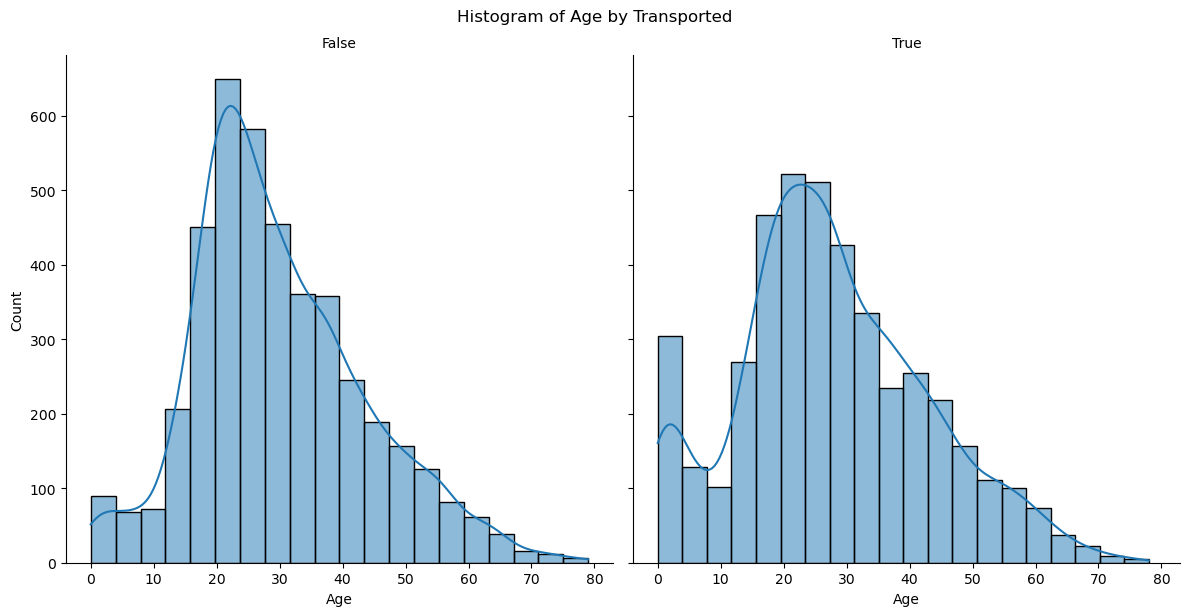

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

g = sns.FacetGrid(main_data, col='Transported', height=6)
g.map(sns.histplot, 'Age', bins=20, kde=True)

# Set titles and labels
g.set_axis_labels('Age', 'Count')
g.set_titles(col_template='{col_name}')
plt.suptitle('Histogram of Age by Transported', y=1.02)

plt.show()

## Age

We can see that there is a slightly larger number of children who were transported, and 20-30-year olds who were not. Maybe we can categorize people into classes based on age and see if there's any association.

In [7]:
def age_class(val):
    
    age_dict = {
		10 : 'child',
        20 : 'teen',
        40 : 'adult',
        60: 'senior',
        100: 'elder'
    }
    
    for i in list(age_dict.keys()):
        if val < i:
            return age_dict[i]
            break

In [8]:
main_data['Age_Class'] = main_data['Age'].apply(age_class)
main_data.Age_Class.value_counts()

Age_Class
adult     4497
senior    1605
teen      1479
child      679
elder      254
Name: count, dtype: int64

In [9]:
success = main_data[main_data['Transported'] == True]
fail = main_data[main_data['Transported'] == False]

In [12]:
ftr_lvls = list(main_data.Age_Class.unique())[:-1]

print('Transport Rate of Age Classes')
print('******************************')
print('')
print('(legend)')
print('name ----> success ----> failure')
print('------------------------------')
for i in range(len(ftr_lvls)):
    s = success[success['Age_Class'] == ftr_lvls[i]].shape[0]
    f = fail[fail['Age_Class'] == ftr_lvls[i]].shape[0]
    print(f'{ftr_lvls[i]} ----> {(s)/(s + f) * 100:.2f} ----> {(f)/(s + f) * 100:.2f}')
    print('')

Transport Rate of Age Classes
******************************

(legend)
name ----> success ----> failure
------------------------------
adult ----> 46.52 ----> 53.48

senior ----> 50.22 ----> 49.78

teen ----> 53.28 ----> 46.72

child ----> 71.13 ----> 28.87

elder ----> 46.85 ----> 53.15



It seems like besides children, most classes are equally spread apart. We'll modify our function to have two levels - `child` and `not child`

In [13]:
def is_child(val):
    if val < 10:
        return True
    else:
        return False 

## Monetary Expenses

Next, let's look at expenditures made on ameneties and see if they have any effect on likeliness to be successfully transported

In [14]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Age_Class     8514 non-null   object 
dtypes: bool(1), float64(6), object(8)
memory usage: 959.4+ KB


In [16]:
numerical_features = [col for col in main_data.columns if main_data[col].dtype == 'float64']
spending_features = [col for col in numerical_features if col != 'Age']

print("Mean total spending:")
print('******************************')
print("")

for feat in spending_features:
    print(f"Feature : {feat}")
    print(f'transported : {success[feat].mean():.2f} ------> not transported: {fail[feat].mean():.2f}')
    print("")

Mean total spending:
******************************

Feature : RoomService
transported : 63.10 ------> not transported: 389.27

Feature : FoodCourt
transported : 532.69 ------> not transported: 382.62

Feature : ShoppingMall
transported : 179.83 ------> not transported: 167.57

Feature : Spa
transported : 61.68 ------> not transported: 564.38

Feature : VRDeck
transported : 69.15 ------> not transported: 543.63



It looks like those who weren't transported spent more money on room service, the spa, and the VR deck. There is a slight bend towards those successfully who spent more at the food court and shopping mall, but overall those not transported spent the lion's share of money. Let's see if we can say the same if we add up all the expenses into one variable. 

In [17]:
success['Exp'] = success.RoomService + success.FoodCourt + success.ShoppingMall + success.Spa + success.VRDeck
fail['Exp'] = fail.RoomService + fail.FoodCourt + fail.ShoppingMall + fail.Spa + fail.VRDeck

In [18]:
print(f"Mean total spending for transported passengers: {success['Exp'].mean():.2f}")
print(f"Mean total spending for non-transported passengers: {fail['Exp'].mean():.2f}")

Mean total spending for transported passengers: 925.02
Mean total spending for non-transported passengers: 2049.82


## Trip Trajectory 

If the factor behind a trip's success or not is in any way related to the destination or starting point of the trip, inspecting the different values of the `HomePlanet` and `Destination` features will bring them to light. 

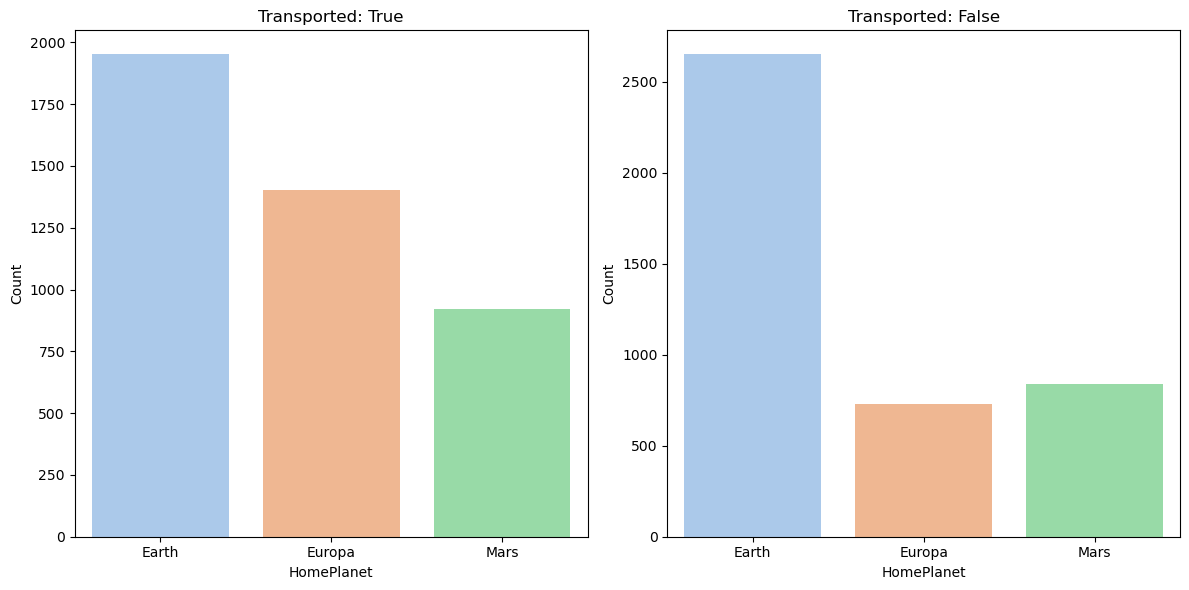

In [19]:
# Define the order of categories
planet_order = ['Earth', 'Europa', 'Mars']

# Convert 'HomePlanet' column to a categorical variable with specified order
main_data['HomePlanet'] = pd.Categorical(main_data['HomePlanet'], categories=planet_order, ordered=True)

# Set up the two bar plots using countplot
plt.figure(figsize=(12, 6))

# Bar plot for Transported = True
plt.subplot(1, 2, 1)
sns.countplot(data=main_data[main_data['Transported'] == True], x='HomePlanet', order=planet_order, palette='pastel')
plt.title('Transported: True')
plt.xlabel('HomePlanet')
plt.ylabel('Count')

# Bar plot for Transported = False
plt.subplot(1, 2, 2)
sns.countplot(data=main_data[main_data['Transported'] == False], x='HomePlanet', order=planet_order, palette='pastel')
plt.title('Transported: False')
plt.xlabel('HomePlanet')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

There isn't much to see here - we can definitely notice that the majority of passengers are from Earth and the minority from Mars. We can also surmise that those from Europa are largely successful in their trip. Let's do this with destination planets. 

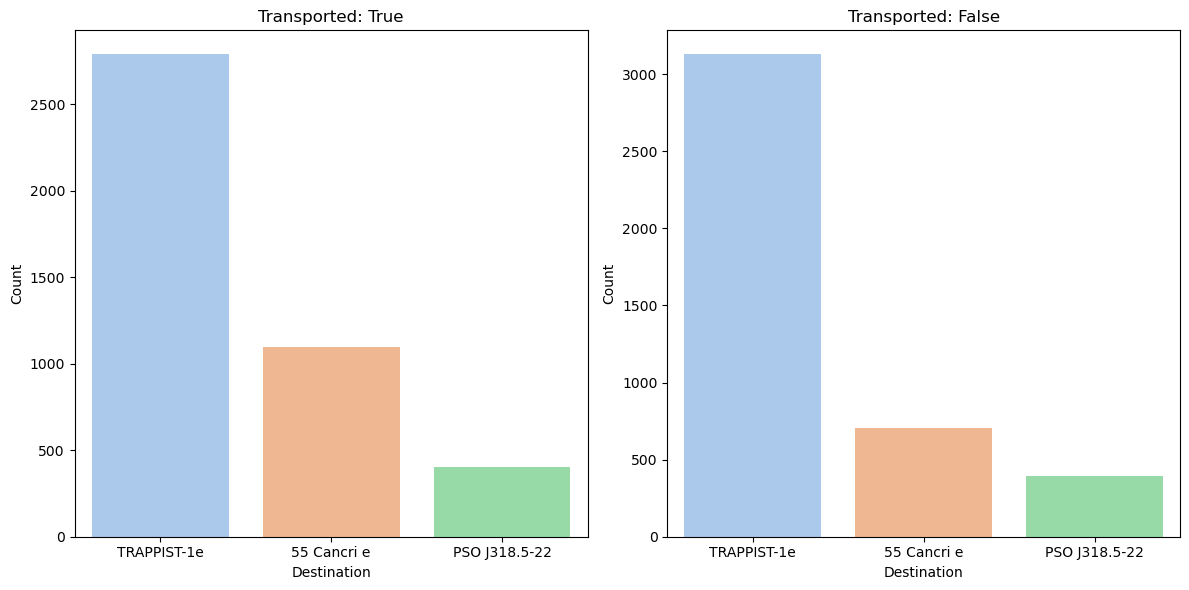

In [20]:
main_data.Destination.value_counts()

# Define the order of categories
planet_order = ['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']

# Convert 'HomePlanet' column to a categorical variable with specified order
main_data['Destination'] = pd.Categorical(main_data['Destination'], categories=planet_order, ordered=True)

# Set up the two bar plots using countplot
plt.figure(figsize=(12, 6))

# Bar plot for Transported = True
plt.subplot(1, 2, 1)
sns.countplot(data=main_data[main_data['Transported'] == True], x='Destination', order=planet_order, palette='pastel')
plt.title('Transported: True')
plt.xlabel('Destination')
plt.ylabel('Count')

# Bar plot for Transported = False
plt.subplot(1, 2, 2)
sns.countplot(data=main_data[main_data['Transported'] == False], x='Destination', order=planet_order, palette='pastel')
plt.title('Transported: False')
plt.xlabel('Destination')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Slightly more succeed than fail that are going to 55 Cancri e, so I think we can combine the variables into one that just dictates the trip. 

In [21]:
### Preprocess data - "trips" variable
def assign_trip(hp, dest):
    
    trip_val = ''
    
    if hp == 'Earth' :
        if dest == 'TRAPPIST-1e':
            trip_val = 'A'
        elif dest == '55 Cancri e':
            trip_val = 'B'
        else:
            trip_val = 'C'
    elif hp == 'Europa':
        if dest == 'TRAPPIST-1e':
            trip_val = 'D'
        elif dest == '55 Cancri e':
            trip_val = 'E'
        else:
            trip_val = 'F'
    elif hp == 'Mars':
        if dest == 'TRAPPIST-1e':
            trip_val = 'G'
        elif dest == '55 Cancri e':
            trip_val = 'H'
        else:
            trip_val = 'I'
            
    return trip_val

In conclusion, it seems we have 3 main legs to pull our decision tree questions from:

            - Age 
		- Expenditures 
		- Trajectory 

To maximize variability, we'll keep the `Age` numerical variable and the `is_child` categorical variable. We'll also truncate the expenditure variables into one called `Exp`, but leave `Spa` and `VRDeck` because of their large discrepancies.

We have one last detail to look at - the `VIP` feature.

In [22]:
print("Percent Success for VIP/non-VIP")
print('******************************')
print("")

s_true = success[success['VIP'] == True].shape[0]
f_true = fail[fail['VIP'] == True].shape[0]
p_true = (s_true) / (s_true+f_true) * 100

s_false = success[success['VIP'] == False].shape[0]
f_false = fail[fail['VIP'] == False].shape[0]
p_false = (s_false) / (s_false+f_false) * 100

print(f"VIP : {p_true}, non-VIP : {p_false}")

Percent Success for VIP/non-VIP
******************************

VIP : 38.19095477386934, non-VIP : 50.63321674104451


There is a slight turn towards VIP's having unsuccessful trips, so we'll keep that in. 

## Data Preprocessing and Feature Engineering 

Now that we've established the best feature transformations to diversify our data, we'll perform the necessary preprocessing steps. They will go as follows

1. Sample the data (I'll take a fifth of the observations since there are more than 6000 in total)

2. Handle nulls (I kept it simple and replaced categorical values with their mode, and age with the mean age. I made the nulls for the expense categories zero, since I'm assuming that means the passenger made no expense of that sort)

3. Do the necessary feature transformations (add the `is_child` variable, the `exp` variable, and the `trips` variable)

4. Select the columns we want and restructure the data 

## Sampling

In [23]:
### pull a sample of the data
def sample_data(data, percentage):
    return data.sample(frac=percentage)

## Handling Nulls

In [24]:
def handle_nulls(data):
     ## Handle nulls 
    med_age = data.Age.median()
    mode_HP = data.HomePlanet.mode()[0]
    mode_VIP = data.VIP.mode()[0]
    mode_CS = data.CryoSleep.mode()[0]
    mode_dest = data.Destination.mode()[0]
    data = data.fillna({'HomePlanet' : mode_HP,
                    'CryoSleep' : mode_CS,
                    'Destination' : mode_dest,
                    'VIP' : mode_VIP,
                    'Age' : med_age,
                    'RoomService' : 0,
                    'FoodCourt' : 0,
                    'ShoppingMall' : 0,
                    'Spa' : 0,
                    'VRDeck' : 0})
    
    return data

## Feature Engineering:


In [25]:
selected_columns = ['CryoSleep', 'Age', 'Child', 'VIP','Exp', 'Spa', 'VRDeck', 'Trip', 'label']

def feature_engineering(data, selected_columns):
    
    ## Create Is_child column:
    data['Child'] = data['Age'].apply(is_child)
    
    ## Create Exp column:
    data['Exp'] = data.RoomService + data.FoodCourt + data.ShoppingMall + data.Spa + data.VRDeck
    
    ## Create trip column
    for i, row in data.iterrows():
        data.loc[i, 'Trip'] = assign_trip(row['HomePlanet'], row['Destination'])
        
    return data[selected_columns]

In [26]:
selected_columns = ['CryoSleep', 'Age', 'Child', 'VIP','Exp', 'Spa', 'VRDeck', 'Trip', 'label']

### Preprocess data - whole flow
def data_preprocess(data, features=selected_columns):
    ## Sampling
    data = sample_data(data, percentage=0.2)
    
    ## rename label
    data['label'] = data.Transported
    
    ## Handle nulls 
    data = handle_nulls(data)

    ## Feature engineering
    final_df = feature_engineering(data, features)
    
    return final_df

In [27]:
prepped_df = data_preprocess(main_data)

In [28]:
prepped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1739 entries, 1681 to 6465
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CryoSleep  1739 non-null   bool   
 1   Age        1739 non-null   float64
 2   Child      1739 non-null   bool   
 3   VIP        1739 non-null   bool   
 4   Exp        1739 non-null   float64
 5   Spa        1739 non-null   float64
 6   VRDeck     1739 non-null   float64
 7   Trip       1739 non-null   object 
 8   label      1739 non-null   bool   
dtypes: bool(4), float64(4), object(1)
memory usage: 152.8+ KB


In [29]:
prepped_df.head()

,CryoSleep,Age,Child,VIP,Exp,Spa,VRDeck,Trip,label
1681,False,40.0,False,False,804.0,73.0,0.0,A,False
1455,False,32.0,False,False,4025.0,1440.0,2114.0,D,False
1353,True,4.0,True,False,0.0,0.0,0.0,A,True
833,False,16.0,False,False,519.0,9.0,0.0,G,False
458,True,27.0,False,False,0.0,0.0,0.0,H,True


We have our prepped dataframe ready to go! Let's get started on the logic for the decision trees. 

# 5. Decision Tree Algorithm

## Entropy and Information Gain 

We begin by getting the most overt mathematics out of the way. We'll need a way to calculate the entropies of a dataset, and the information gain of the pre-split and post-split versions for when we decide what splits to make. 

For entropy we'll have to do the following
         
		 - get the probabilities of Transported being True and False
		 - multiply each by log_2 * its probabilities
		 - add them together 

For information gain, we'll do the following
         
		 - Get the entropy value before, and the entropy values for the two datasets after the split
		 - multiply the post-split datasets' entropy values by their proportion in the full dataset
		 - Add them all together as per the formula 

This process is detailed below in code. 

In [30]:
### Calculate Entropy
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [31]:
### Lowest Overall Entropy
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [32]:
### information gain
def calculate_info_gain(data_unsplit, data_below, data_above):
    
    unsplit_entropy = calculate_entropy(data_unsplit)
    overall = calculate_overall_entropy(data_below, data_above)
    
    return unsplit_entropy - overall

## Recursive Aspect - Building the Tree

### Structure

1. We start with the whole dataset and conduct our initial split, finding the best possible split by trying out different ones and finding the one that maximizes information gain

2. We will split the data, and check if any of the nodes created are pure 
      
	  a. If they are, we will terminate that node there and classify the data within as either a `True` node or `False` node

	  b. If not, we will ask another question and split the data again

3. We should return with a fully developed tree that ends at pure nodes. 

### Terminal Node

Let's start with devising a way to check the purity of our node. The logic here is that all members of the node must have the same value for their target column. The following code determines whether a node is pure. 

In [33]:
### Data Purity
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column) ### one value if they're all the same 

    if len(unique_classes) == 1:
        return True
    else:
        return False

If we find a pure node, the following code classifies the node as one of the levels of the target. 

In [34]:
### Classification
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

## Making the Best Split 

There needs to be a small caveat here. **Random Forest** requires feature bagging, discussed earlier, to vary the features from which it constructs trees. Therefore I decided to put this functionality directly in the tree-making architecture. Below is a function called `feature_scramble` which does just that and returns a list of features. I will call on `feature_scramble` and use that list of features to determine my best splits. Notice `max_features` is a variable I can set. 

### Splitting the Node 

In [35]:
### Feature sampling 
def feature_scramble(data, max_features):
    
    feature_ls = list()
    num_features = list(data.shape)[1] - 2
    
    while len(feature_ls) <= max_features:
        feature_idx = random.sample(range(num_features), 1)
        if feature_idx not in feature_ls:
            feature_ls.extend(feature_idx)
    
    unique = []
    
    for val in feature_ls:
        if val not in unique:
            unique.append(val)
    
    return unique


My logic behind getting all potential splits highlights the versatility of decision trees:

         - For categorical columns, I can just split a node at each value of the feature (ie. 'Trip' == A ---> True/False)
         - For numerical columns, I can split the features at the numerical points between the instances. If I have a point at 100, and another at 102, I can split the feature at 101 to get values for either node

After getting back a list of all potential splits I can use I will then iterate through my dataset testing these out, and getting back information gain scores. That way I can pick the best one at every iteration. 

The following shows how I get all potential splits. I scramble the features to give me a unique feature list to pull splits from, and return the unique values from said features.

In [36]:
### Potential Splits
def get_potential_splits(data, max_features):
    
    
    potential_splits = {}
    target_features = feature_scramble(data, max_features=max_features)
    
    for column_index in target_features:          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

Since the way I make splits is different for different types of features (for numerical features, I'll find values in between points, and for categorical features, each split will be a unique value of that feature), I will need a way to differentiate categorical and numerical features. I do so in a list.

In [37]:
### Determine Feature Type
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

The following function takes information about a split column, a value to split on, and returns the two resulting dataframes. This is where I execute the actual split - note that if the data type is continuous, I base my split condition on a range of values, whereas for categorical features, I test equivalency to its discrete options. 

In [40]:
### Split Data
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

The following function tests out all potential splits and finds the one with the highest overall information gain. 

I execute each potential split for each feature, and find the resultant information gain from the split. Subsequently, I return the split with the best information gain. 

In [41]:
### Determine Best Split
def determine_best_split(data, potential_splits):
    
    best_split_column = None
    best_split_value = None
    
    overall_IG = -999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_IG = calculate_info_gain(data, data_below, data_above)

            if current_IG >= overall_IG:
                overall_IG = current_IG
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

### Overall Tree Structure 

Now that we have a mechanism to pick our next node, or terminate a path at a pure node, we can develop the rest of our tree architecture. 

We start by creating some global constants to help us with the split (instantiated with a counter so it doesn't keep executing), and begin by checking for our base case (a pure node). If the data in question is not a pure node, we proceed to:

1. Get potential splits

2. Find the best one

3. Split the data accordingly 

4. Run the algorithm again for each subset.

We do this until every recursive instance of the function terminates at a pure node, or until we reach a maximum number of iterations. Note that we can control the maximum depth (number of trees). I also set a value for minimum samples so that we can terminate a node if it has no data or only one instance, because that gives us no information. 

In [42]:
### Decision Tree
def decision_tree_algorithm(df, counter, min_samples, max_depth, max_features): 
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, max_features)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, max_features)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, max_features)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

### Example Execution - Train test split 

Let's see some of this in action. I'm creating a train test split function below (based on a given proportion, divides the data into a set to train on and a set to predict on) for the sake of demonstrating the prediction performance of one tree, but we will implement another kind of model evaluation tactic, **cross validation**, further below. 

In [43]:
### Train Test Split
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


In [44]:
train_df, test_df = train_test_split(prepped_df, test_size=0.2)

In [45]:
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

train shape: (1391, 9)
test shape: (348, 9)


In [46]:
tree = decision_tree_algorithm(train_df, counter=0, min_samples=2, max_depth=5, max_features=5)

In [47]:
pprint(tree)

{'Exp <= 0.0': [True,
                {'Exp <= 2414.0': [{'Spa <= 480.0': [False,
                                                     {'Exp <= 889.0': [False,
                                                                       {'Exp <= 891.0': [True,
                                                                                         False]}]}]},
                                   {'Spa <= 1301.0': [{'Exp <= 4393.0': [{'VRDeck <= 1057.0': [True,
                                                                                               False]},
                                                                         {'VRDeck <= 2260.0': [True,
                                                                                               False]}]},
                                                      False]}]}]}


Further below, we create a way to calculate the accuracy of a trained tree on itself. For now, to demonstrate this example, I'll call it from my personal helper functions.

In [48]:
from helper_functions import *

acc = calculate_accuracy(train_df, tree)

In [49]:
print(f"accuracy on training set: {acc*100:.2f} %")

accuracy on training set: 77.21 %


Let's see what happens if we increase the maximum number of features.

In [50]:
tree2 = decision_tree_algorithm(train_df, counter=0, min_samples=2, max_depth=5, max_features=8)
acc2 = calculate_accuracy(train_df, tree2)

In [51]:
pprint(tree2)

{'Exp <= 10154.0': [{'Spa <= 480.0': [{'CryoSleep = True': [True,
                                                            {'label = True': [{'Age <= 12.0': [True,
                                                                                               False]},
                                                                              {'Child = True': [False,
                                                                                                True]}]}]},
                                      {'label = True': [{'Exp <= 2542.0': [False,
                                                                           {'Spa <= 1301.0': [True,
                                                                                              False]}]},
                                                        {'Exp <= 2414.0': [True,
                                                                           {'Spa <= 1018.0': [False,
                                                 

In [52]:
print(f"accuracy on training set: {acc2*100:.2f} %")

accuracy on training set: 35.37 %


This is one of the pitfalls of feature bagging that random forest alleviates through strong numbers. A lot of feature combinations may be unpalatable for decision trees but they are eschewed in favor of the more compatible trees. 

# 6. Random Forest 

One benefit of bootstrapping lies in a curious mathematical tendency, the mathematical scope of which is beyond this notebook. There is a great StackOverflow post that explains and demonstrates the phenomenon:

https://stats.stackexchange.com/questions/88980/why-on-average-does-each-bootstrap-sample-contain-roughly-two-thirds-of-observat

Essentially, bootstrapping reliably results in about 1/3 of the data being left out. We can train our trees on the bootstrapped subset, and test their accuracy on the remaining 1/3. This is often called the *out-of-bag* sample. 

## Bootstrapping

In the following code I draw a bootstrap by randomly selecting (with replacement) a list of numbers in the range of the indices, grabbing the corresponding indices and placing them into a new dataframe.

I create the out-of-bag sample by simply selecting the indices which haven't been included in the bootstrap. 

In [53]:
### Draw bootstrap
def draw_bootstrap(data):
    bootstrap_indices = list(np.random.choice(range(len(data)), len(data), replace = True))
    oob_indices = [i for i in range(len(data)) if i not in bootstrap_indices]
    
    data_bootstrap = data.iloc[bootstrap_indices]
    
    data_oob = data.iloc[oob_indices]
    
    return data_bootstrap, data_oob



## Using the Trees to Predict 

Before we go ahead, we need a way to call the trees to predict, and judge their outcome. This is what we skipped over when we saw `calculate_accuracy()` above. 

The following code classifies a single instance by taking it through a tree. Notice that this is also recursive. We break down the instance feature by feature until we reach a terminal node to predict on. Also noteworthy is the consideration for categorical features. Remember that you're looking for a range in continuous variables, but exact equivalency in categorical variables. 

In [54]:
### Classify an Example
def classify_example(example, tree):
    question = list(tree.keys())[0]
    # print(question)
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)
    

The following code uses the tree to predict all instances in the dataset, and appends its prediction as a column. After doing so, it finds the mean similarity of that column, and returns it as the accuracy score.

In [55]:
### Calculate Model Accuracy
def calculate_accuracy(df, tree):
    
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["label"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

## Random Forest Architecture 

The following is the training algorithm for the random forest. 

We create a list to store our trees.

Then, for each estimator, we draw our **bootstrap**, and run our **decision tree** algorithm. Remember, we execute **feature bagging** within the algorithm, during the process to determine the best split. 

In [56]:
### Random Forest 
def random_forest(data, n_estimators, max_features=5, max_depth=5, min_samples=2):
    
    tree_ls = list()
    # oob_ls = list()
    
    for i in range(n_estimators):
        data_boot, data_oob = draw_bootstrap(data)
        tree = decision_tree_algorithm(data_boot, counter=0, min_samples=min_samples, max_depth=max_depth, max_features=max_features)
        tree_ls.append(tree)
    
    return tree_ls

# 7. Model Evaluation and Hyperparameter Tuning 

To evaluate our model and tune hyperparameters, we'll implement cross-validation to increase the amount of randomness within the whole process. Cross-validation essentially slices the dataframe into 2 randomly determined subsets (a large *training* set and a smaller *test* set) a number of times, called *folds*, trains a model and evaluates it on the training and test set respectively, and records the result. It's an elegant way to get a more holistic view of your model's true performance. 

Before we do so, we have to establish some logic that allows the random forest to predict on a dataset. 

We basically have each tree in the list of random forest trees make a prediction and tally up the votes. 

The following code gets votes for predictions for a single row and returns the most common (the majority vote). 

## Generating a Prediction 

In [57]:
### Predict a single instance 
def predict(val, trees):
    
    votes = []
    
    for tree in trees:
        votes.append(classify_example(val, tree))
    
    counter = Counter(votes)
    
    return counter.most_common(1)[0][0]

The following code predicts an entire test set. 

In [58]:
### Create prediction series 
def prediction(data, trees):
    
    predictions = []
    
    for i in range(data.shape[0]):
        result = predict(data.iloc[i], trees)
        predictions.append(result)
    
    return predictions

The following code evaluates the accuracy of the random forest's predictions, much like `calculate_accuracy()` did for our tree. 

In [59]:
### Evaluate accuracy of random forest 
def evaluate(data, predictions, label='label'):
    data['prediction'] = predictions 
    data['correct'] = data['prediction'] == data[label]
    return data['correct'].mean()

The following puts it all together. 

In [60]:
### Evaluate RF model with data 
def model_testing(data, trees):
    predictions = prediction(data, trees)
    acc = evaluate(data, predictions)
    
    return acc

Let's see what it looks like so far:

In [61]:
trees_ls = random_forest(train_df, n_estimators=10, max_features=5, max_depth=5, min_samples=2)
acc_rf = model_testing(train_df, trees_ls)

In [62]:
acc

0.7721063982746226

## Cross-Validation 

Cross validation ins an invaluable tool to glean a more reliable understanding of a model's accuracy. As mentioned above, the basic logic of cross validation takes a dataset and splits it into a given number of unique training and testing pairs, the number specified by the user. Conventionally cross validation is performed with 5-10 iterations, called *folds*. This allows one dataset to transform into five different instances of training and test sets, and gives the model five separate attempts at prediction. 

Now we implement our cross-validation logic. We'll get the indices for the training and test for each fold in a list, then use the list to get the instances from the corresponding positions 

The following code returns the train and test indices for each fold as a tuple of lists. Essentially, for **k** (the hyperparameter number of instances) folds, I divide the entire length of my instances by that number.

Assume that I have a dataset $D$, with 1000 entries, and I would like to perform a $5$-fold cross-validation on a model using this data. 

The resultant datasets, 

which we will call $D_1, D_2, D_3, D_4$, and $D_5$, 

all have 200 entries ($1000/5 = 200$).

Then, for each of the $k = 5$ iterations, we will make one subset the test set, and combine the other 4 into training sets. Ultimately we have five training sets as follows:

1. 

$D_\text{train} = D_1, D_2, D_3, D_4$

$D_\text{test} = D_5$

2. 

$D_\text{train} = D_2, D_3, D_4, D_5$

$D_\text{test} = D_1$

3. 

$D_\text{train} = D_5, D_1, D_3, D_4$

$D_\text{test} = D_2$

4. 

$D_\text{train} = D_5, D_1, D_2, D_4$

$D_\text{test} = D_3$

5. 

$D_\text{train} = D_5, D_1, D_2, D_3$

$D_\text{test} = D_4$

Here, we designate the desired instances for each fold's training and testing set, by using a list of indices whose positions we will find our entries. 

In [63]:
### Create indices for cross validation 
def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

Once we have our folds, we can execute the random forest for each fold and return the scores. 


In [64]:
### Get cross val scores
def cross_val(data, k, estimators):
    
    scores = []
    
    fold_indices = kfold_indices(data, k)
    
    for train_indices, test_indices in fold_indices:
        data_train = data.iloc[train_indices]
        data_test = data.iloc[test_indices]
        
        trees_ls = random_forest(data_train, n_estimators=estimators)
        fold_score = model_testing(data_test, trees_ls)
        
        scores.append(fold_score)
    
    print(f'mean accuracy score: {np.mean(scores)}')
    
    return scores

In [65]:
scores = cross_val(prepped_df, k=5, estimators=10)

mean accuracy score: 0.7538904899135448


In [66]:
scores

[0.7521613832853026,
 0.7665706051873199,
 0.7204610951008645,
 0.7435158501440923,
 0.7867435158501441]

We have a comprehensive list of scores for one set of hyperparameters on our training data. Our last leg of this process is **hyperparamter** tuning - the process of trying out multiple hyperparameters and trying to see how the model changes behavior. 

We have 3 hyperparameters - maximum depth, maximum number of features, and maximum number of estimators. 

So far we have been defaulting to a depth of 5, maximum number of 5 features to choose from, and 10 estimators. 

A good place to start is to choose values above and below our original hyperparameters, and test out cross validation on all of them. This is called *Grid Search Cross Validation*, and Sci-kit Learn has a function that impliments GridSearchCV very efficiently. However, in the spirit of this notebook so far, we'll be making our own. 

The logic is really quite simple. We amass a dictionary whose keys are the different types of hyperparameters (*max_depth*, *max_features*, and *n_estimators*), and store lists of values for each we want to try. Then we iterate through the dictionary and try every combination of hyperparameters (like we're iterating through a *grid* of values). It's important to note that this form of GridSearchCV implementation is computationally taxing, which is definitely something to consider when pondering this approach on much larger datasets. 

Let's first construct our dictionary of hyperparameter values. 

In [69]:
def create_hp_dict(depth_vals, feats_vals, est_vals):
    
    hp_grid = {
		'max_depth' : depth_vals,
		'max_features' : feats_vals,
		'n_estimators' : est_vals
	}
    
    return hp_grid

In [72]:
depth_vals = [2, 6, 8]
feats_vals = [3, 6, 10]
est_vals = [5, 10, 20]

hp_grid = create_hp_dict(depth_vals, feats_vals, est_vals)

So far I've been using default values when running the Random Forest algorithm. We'll modify the cross validation function so it has the option to input different hyperparameters.

In [78]:
### Get cross val scores
def cross_val_modded(data, k, estimators, max_depth, max_features):
    
    scores = []
    
    fold_indices = kfold_indices(data, k)
    
    for train_indices, test_indices in fold_indices:
        data_train = data.iloc[train_indices]
        data_test = data.iloc[test_indices]
        
        trees_ls = random_forest(data_train, n_estimators=estimators, max_depth=max_depth, max_features=max_features)
        fold_score = model_testing(data_test, trees_ls)
        
        scores.append(fold_score)
    
    print(f'mean accuracy score: {np.mean(scores)}')
    
    return scores

In [87]:
def grid_searchCV(data, k, hp_grid):
    
    results_dict = {}
    
    for depth in hp_grid['max_depth']:
        for feat in hp_grid['max_features']:
            for est in hp_grid['n_estimators']:
                results_key = (' ').join([str(depth), str(feat), str(est)])
                results_value = cross_val_modded(data, k, estimators=est, max_depth = depth, max_features=feat)
                results_dict[results_key] = results_value
    
    return results_dict

In [88]:
results_dict = grid_searchCV(prepped_df, k=5, hp_grid=hp_grid)

mean accuracy score: 0.7463976945244957
mean accuracy score: 0.745821325648415
mean accuracy score: 0.7463976945244957
mean accuracy score: 0.7342939481268012
mean accuracy score: 0.7463976945244957
mean accuracy score: 0.7463976945244957
mean accuracy score: 0.7452449567723343
mean accuracy score: 0.7463976945244957
mean accuracy score: 0.745821325648415
mean accuracy score: 0.7544668587896254
mean accuracy score: 0.7585014409221903
mean accuracy score: 0.760806916426513
mean accuracy score: 0.7533141210374639
mean accuracy score: 0.7567723342939481
mean accuracy score: 0.7671469740634006
mean accuracy score: 0.7625360230547551
mean accuracy score: 0.7625360230547551
mean accuracy score: 0.7642651296829971
mean accuracy score: 0.7556195965417867
mean accuracy score: 0.760806916426513
mean accuracy score: 0.7602305475504323
mean accuracy score: 0.7556195965417868
mean accuracy score: 0.7515850144092219
mean accuracy score: 0.7567723342939481
mean accuracy score: 0.7556195965417867
mean

In [94]:
for val in results_dict.keys():
    results_dict[val] = sum(results_dict[val]) / len(results_dict[val])


TypeError: 'numpy.float64' object is not iterable

In [96]:
key_highest_value = max(results_dict, key=results_dict.get)

In [102]:
best_params = key_highest_value.split(' ')
param_labels = ['max depth', 'max features', 'number of estimators']

print("Best Parameters:")

for i in range(len(param_labels)):
    print(f"{param_labels[i]} : {best_params[i]}")
print('')
print(f"Best Mean Score : {results_dict[key_highest_value] :.2f}")

Best Parameters:
max depth : 6
max features : 6
number of estimators : 20

Best Mean Score : 0.77


# Conclusion

Ultimately it seems our best random forest classifier (given our choices) is one with a maximum tree depth of 6, a maximum feature pool of 6, and 20 estimators. This can be expounded upon with multitudes of complexity, but the goal of this notebook was to achieve the entire flow by using nothing but math, which we have now successfully accomplished. The last task to perfect the model before deployment would be to make our parameter grid more robust and test out even more hyperparameters. 

There is an idea that artifical intelligence is this vast leap in computational structure that is inaccessible for the standard data scientist to understand. Though this is only a drop in the ocean of mechanisms that have lead to AI being what it is today, this notebook shows that at its core, machine learning is pattern recognition through logic and mathematics. I hope to make more of these with different types of algorithms, and I truly believe this practice allows a data scientist into a new world of model customization and a deeper understanding for the goals, benchmarks, and drawbacks we undertake when we approach these problems. 